In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Download and Explore Dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 39s 0us/step


There are in total 3,670 images

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Plot one image example

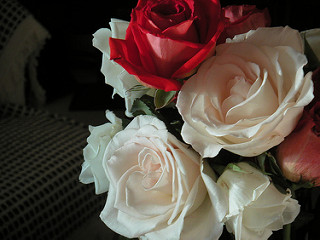

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

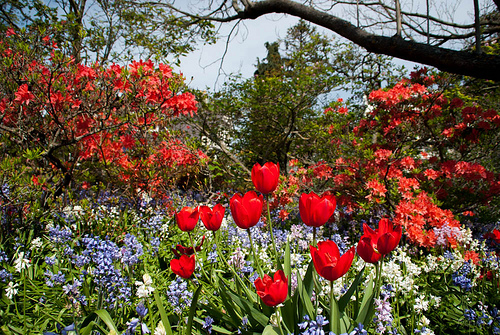

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[5]))

### Load Images from directory
Used Utility:
``` python
tf.keras.utils.image_dataset_from_directory
```
Define some parameters for dataloader. Split images into 80% training and 20% validation.

In [9]:
batch_size = 64
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


#### Get the class names for image dataset

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### Visualize some data

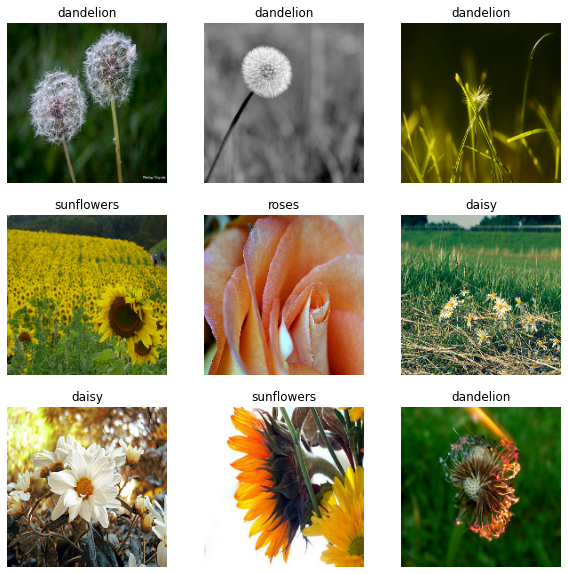

In [14]:
plt.figure(figsize=(10, 10))
plt.tight_layout()
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

#### Use buffered prefetching, so that I/O won't be a bottleneck when loading images

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#### RGB channels are in [0, 255] range for each color channel. Standardize values to be within [0, 1] by using
``` python
tf.keras.layers.Rescaling
```
Construct NN model. 

Conv2D() padding option:
"valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input. data_format: A string, one of channels_last (default) or channels_first.

MaxPooling2D() is alias of MaxPool2D(). It's purpose is to downsample input along its spatial dimensions (height and width).

Flatten() flattens the output tensor.

Dense() inplements operation:
``` python
output = activation(dot(input, kernel) + bias)
```
where activation is some specified activation function

In [22]:
num_classes = len(class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)        0

#### Start model training over a specified number of epochs

In [25]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 10s 25ms/step - loss: 1.2622 - accuracy: 0.4758 - val_loss: 1.0312 - val_accuracy: 0.5804
Epoch 2/20
92/92 [==============================] - 1s 16ms/step - loss: 0.9614 - accuracy: 0.6250 - val_loss: 0.8990 - val_accuracy: 0.6540
Epoch 3/20
92/92 [==============================] - 1s 16ms/step - loss: 0.7654 - accuracy: 0.7040 - val_loss: 0.9474 - val_accuracy: 0.6444
Epoch 4/20
92/92 [==============================] - 1s 16ms/step - loss: 0.5560 - accuracy: 0.7984 - val_loss: 0.9106 - val_accuracy: 0.6717
Epoch 5/20
92/92 [==============================] - 1s 16ms/step - loss: 0.3456 - accuracy: 0.8791 - val_loss: 1.0097 - val_accuracy: 0.6471
Epoch 6/20
92/92 [==============================] - 1s 15ms/step - loss: 0.1955 - accuracy: 0.9407 - val_loss: 1.0888 - val_accuracy: 0.6785
Epoch 7/20
92/92 [==============================] - 1s 15ms/step - loss: 0.1002 - accuracy: 0.9710 - val_loss: 1.2713 - val_accuracy: 0.6744
Epoch 8/20
9

#### Visualize Results of Training

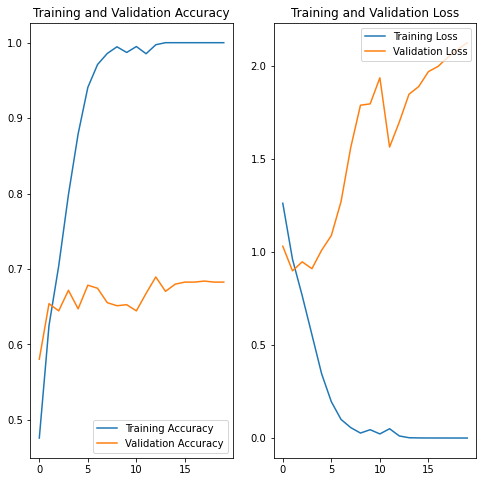

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model has only achieved ~70% Validation accuracy as compared to training accuracy. This is a sign of overfitting. 

##### When there is a small number of training examples, model can learn from unwanted noises, so that it impacts the overall performance of the model. One ways to deal with overfitting is data augmentation, the process in which additional training data is generated by performing image transformations.

##### Augmentation is implemented using the following utilities:
``` python
tf.keras.layers.RandomFlip
tf.keras.layers.RandomRotation
tf.keras.layers.RandomZoom
```

In [28]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        'horizontal',
        input_shape=(img_height, img_width, 3)
    ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

#### Visualize Augmnentation

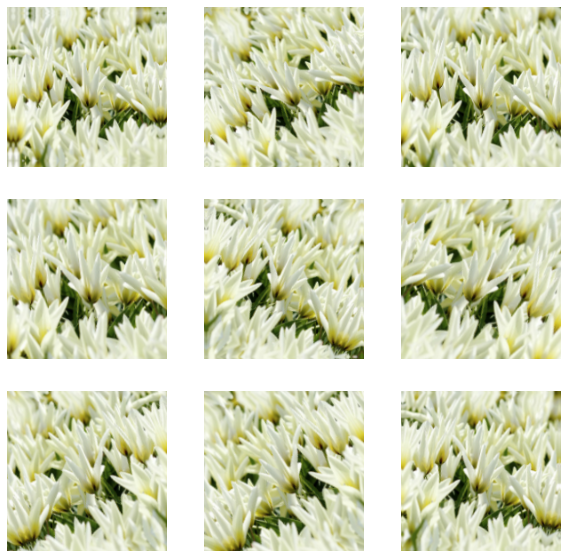

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

In [34]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
92/92 [==============================] - 2s 19ms/step - loss: 0.4075 - accuracy: 0.8447 - val_loss: 0.8484 - val_accuracy: 0.7439
Epoch 2/40
92/92 [==============================] - 2s 18ms/step - loss: 0.4022 - accuracy: 0.8464 - val_loss: 0.8376 - val_accuracy: 0.7439
Epoch 3/40
92/92 [==============================] - 2s 18ms/step - loss: 0.3492 - accuracy: 0.8696 - val_loss: 0.9486 - val_accuracy: 0.7248
Epoch 4/40
92/92 [==============================] - 2s 18ms/step - loss: 0.3525 - accuracy: 0.8757 - val_loss: 0.7982 - val_accuracy: 0.7480
Epoch 5/40
92/92 [==============================] - 2s 18ms/step - loss: 0.3097 - accuracy: 0.8811 - val_loss: 0.9755 - val_accuracy: 0.7425
Epoch 6/40
92/92 [==============================] - 2s 18ms/step - loss: 0.3059 - accuracy: 0.8839 - val_loss: 0.9084 - val_accuracy: 0.7411
Epoch 7/40
92/92 [==============================] - 2s 18ms/step - loss: 0.2970 - accuracy: 0.8876 - val_loss: 0.9218 - val_accuracy: 0.7371
Epoch 8/40
92

#### Visualize training results

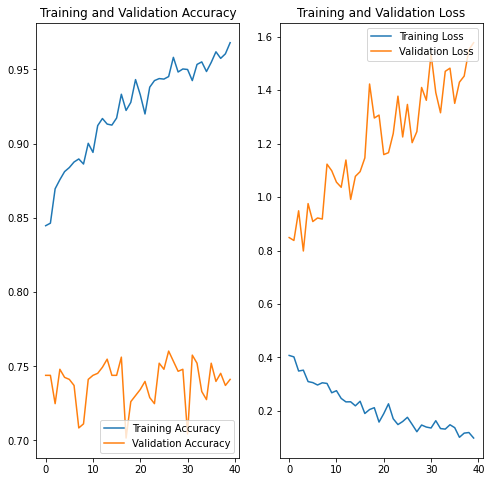

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Prediction

In [36]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 99.16 percent confidence.


Image 0 Class (P): sunflowers Acc: 99.16%
Image 1 Class (P): sunflowers Acc: 99.16%
Image 2 Class (P): sunflowers Acc: 99.16%
Image 3 Class (P): sunflowers Acc: 99.16%
Image 4 Class (P): sunflowers Acc: 99.16%
Image 5 Class (P): sunflowers Acc: 99.16%
Image 6 Class (P): sunflowers Acc: 99.16%
Image 7 Class (P): sunflowers Acc: 99.16%
Image 8 Class (P): sunflowers Acc: 99.16%


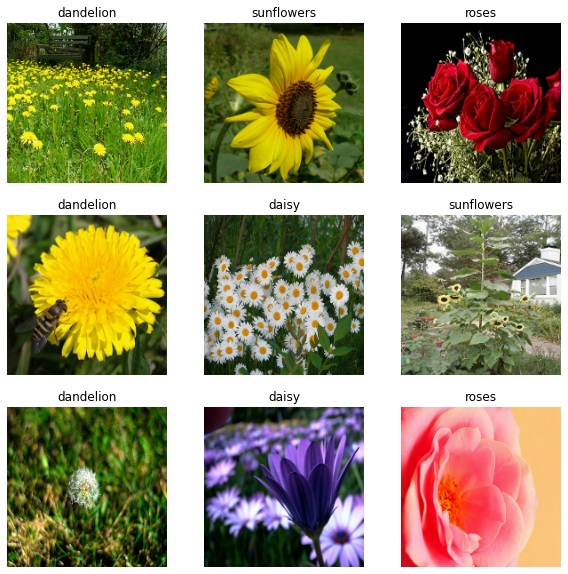

In [39]:
plt.figure(figsize=(10, 10))
# plt.tight_layout()
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy().astype('uint8')
        prediction = model.predict(tf.expand_dims(image, 0))
        score = tf.nn.softmax(prediction[0])
        plt.imshow(image)
        plt.title(class_names[labels[i]])
        print('Image {} Class (P): {} Acc: {:.2f}%'.format(i, class_names[np.argmax(score)], 100 * np.max(score)))
        plt.axis('off')